In [ ]:
import numpy as np
  #The filters
from scipy import ndimage
  #important for computer vision
import cv2
import math
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from IPython.display import HTML

In [ ]:
def denoise_median(img, size):
  image_denoised_med = ndimage.median_filter(img, size, footprint=None, mode='wrap', cval=0.0)
  return image_denoised_med

In [ ]:
def denoise_box(img, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size ** 2)
    image_denoised_box = cv2.filter2D(img, -1, kernel)
    return image_denoised_box

In [ ]:
def denoise_gauss(img, kernel_size, sig):

    gausskernel = []
    kernelrad = (kernel_size-1)/2
    for i in range (kernel_size):
      col = []
      for j in range (kernel_size):
        distance2 = (abs(i-kernelrad)*abs(i-kernelrad)) + (abs(j-kernelrad)*abs(j-kernelrad))

        gaussval = math.exp(-((distance2)/(2*sig*sig)))
        col.append (gaussval)
      gausskernel.append(col)
    gausskernel = gausskernel/np.sum(gausskernel)


    image_denoised_gauss = cv2.filter2D(img, -1, gausskernel)

    return image_denoised_gauss


In [ ]:
def denoise_geometric_mean(img, kernel_size):
  #Greyscale Fix
  if img.ndim == 2:  # If the image is grayscale
    img = img[..., np.newaxis]  # Add a channel dimension

  padded_img = np.pad(img, ((kernel_size // 2, kernel_size // 2),
                             (kernel_size // 2, kernel_size // 2),
                             (0, 0)), mode='reflect')

  height, width, channels = img.shape

  denoised_img = np.zeros_like(img, dtype=np.float32)

  for i in range(height):
    for j in range(width):
      for c in range(channels):
        neighborhood = padded_img[i:i + kernel_size, j:j + kernel_size, c]

        denoised_img[i, j, c] = np.prod(neighborhood)**(1.0 / neighborhood.size)

  denoised_img = np.clip(denoised_img, 0, 255).astype(np.uint8)

  if img.shape[-1] == 1:
    return denoised_img.squeeze()
  else:
    return denoised_img

In [ ]:
def add_sp_noise(img, prob):
  noisy_img = np.copy(img)
  thres = 1 - prob
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      rdn = np.random.random()
      if rdn < prob:
        noisy_img[i][j] = 0  # Pepper noise
      elif rdn > thres:
        noisy_img[i][j] = 255  # Salt noise
      else:
        noisy_img[i][j] = img[i][j]
  return noisy_img

In [ ]:
def add_gauss_noise(img, mean=0, std_dev=25):
  noise = np.random.normal(mean, std_dev, img.shape)

  noisy_image = img + noise

  noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

  return noisy_image

In [ ]:
def calculate_psnr(img, denoised_img):
  #Higher is better
  mse = np.mean((img - denoised_img)**2)
  if mse == 0:
    return float('inf')  # If MSE is 0, PSNR is infinity
  max_pixel = 255.0  # Assuming 8-bit images
  psnr_score = 20 * np.log10(max_pixel / np.sqrt(mse))

  if psnr_score > 30:
    print(f"PSNR score: {psnr_score}; Very Good Match")
  elif psnr_score > 20:
    print(f"PSNR score: {psnr_score};  Acceptable Match")
  elif psnr_score < 20:
    print(f"PSNR score: {psnr_score}; Poor Match")
  return psnr_score

In [ ]:
def calculate_ssim(img, denoised_img):
  #Closer to 1 is better
  ssim_score, _ = ssim(img, denoised_img, full=True)
  if ssim_score == 1.0:
      print(f"SSIM: {ssim_score}; Perfect Match")
  elif ssim_score > 0.9:
      print(f"SSIM: {ssim_score}; Very Good Match")
  elif ssim_score > 0.8:
      print(f"SSIM: {ssim_score};  Acceptable Match")
  elif ssim_score < 0.8:
      print(f"SSIM: {ssim_score}; Poor Match")
  return ssim_score

In [ ]:
def calculate_mse(img, denoised_img):
  #Lower is better
  mse_score = np.mean((img - denoised_img) ** 2)
  if mse_score < 50:
    print(f"MSE score: {mse_score}; Very Good Match")
  elif mse_score < 100:
    print(f"MSE score: {mse_score};  Acceptable Match")
  elif mse_score > 100:
    print(f"MSE score: {mse_score}; Poor Match")
  return mse_score

Text(0.5, 1.0, 'Original Image')

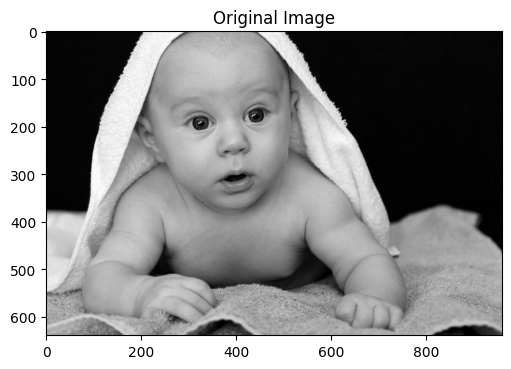

In [ ]:
img = cv2.imread('/content/baby-20374_960_720.jpg', cv2.IMREAD_GRAYSCALE)
#img2 = cv2.imread('/content/lowcontrastnoise.png')
#img3 = cv2.imread('/content/GaussianNoise.png')

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

#plt.subplot(1, 3, 2)
#plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
#plt.title('Image 2')

#plt.subplot(1, 3, 3)
#plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
#plt.title('Image 3')
#plt.show()

In [ ]:
#Making the image noisy

noisy_img = add_sp_noise(img, 0.05)
noisy_imgGauss = add_gauss_noise(img)

Text(0.5, 1.0, 'Gaussian Noise')

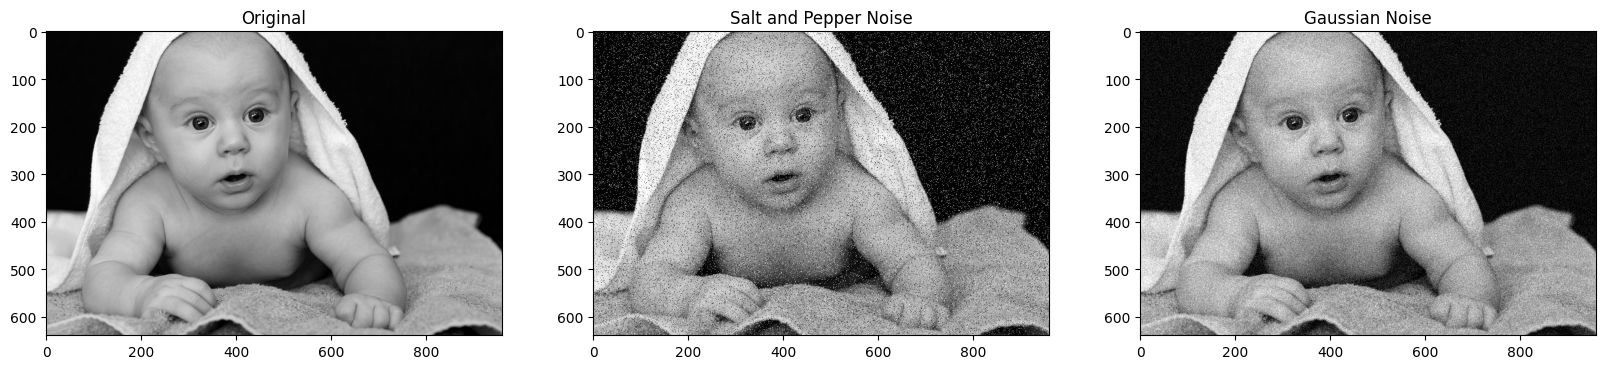

In [ ]:
#Comparing
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB))
plt.title('Salt and Pepper Noise')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(noisy_imgGauss, cv2.COLOR_BGR2RGB))
plt.title('Gaussian Noise')

In [ ]:
denoised_img_med = denoise_median(noisy_img, 3)
denoised_gauss_med = denoise_median(noisy_imgGauss, 3)

In [ ]:
denoised_img_box = denoise_box(noisy_img, 5)
denoised_gauss_box = denoise_box(noisy_imgGauss, 5)

In [ ]:
denoised_geometric_mean = denoise_geometric_mean(noisy_img, 2)
denoised_gauss_geometric = denoise_geometric_mean(noisy_imgGauss, 2)

In [ ]:
denoised_img_MedtoBox = denoise_median(denoise_box(noisy_img, 5), 3)
denoised_gauss_MedtoBox = denoise_median(denoise_box(noisy_imgGauss, 5), 3)

In [ ]:
denoised_img_BoxtoMed = denoise_box(denoise_median(noisy_img, 3), 5)
denoised_gauss_BoxtoMed = denoise_box(denoise_median(noisy_imgGauss, 3), 5)

In [ ]:
denoised_img_gauss = denoise_gauss(noisy_img, 5, 1.5)
denoised_gauss_gauss = denoise_gauss(noisy_imgGauss, 5, 1.5)

Text(0.5, 1.0, 'Denoised Gaussian')

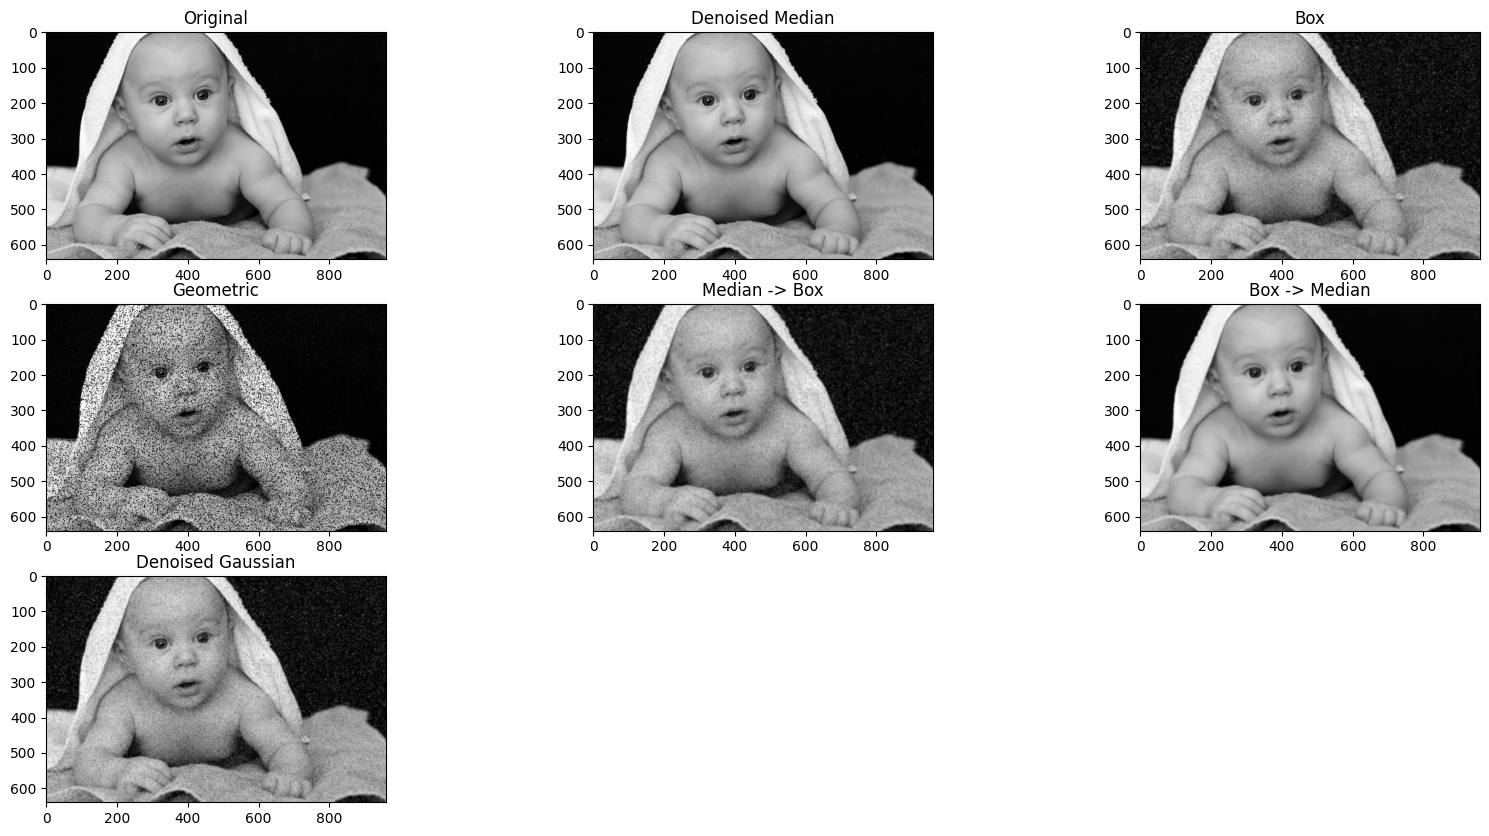

In [ ]:
#Comparing
plt.figure(figsize=(20, 10))

plt.subplot(3, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original')

plt.subplot(3, 3, 2)
plt.imshow(cv2.cvtColor(denoised_img_med, cv2.COLOR_BGR2RGB))
plt.title('Denoised Median')

plt.subplot(3, 3, 3)
plt.imshow(cv2.cvtColor(denoised_img_box, cv2.COLOR_BGR2RGB))
plt.title('Box')

plt.subplot(3, 3, 4)
plt.imshow(cv2.cvtColor(denoised_geometric_mean, cv2.COLOR_BGR2RGB))
plt.title('Geometric')

plt.subplot(3, 3, 5)
plt.imshow(cv2.cvtColor(denoised_img_MedtoBox, cv2.COLOR_BGR2RGB))
plt.title('Median -> Box')

plt.subplot(3, 3, 6)
plt.imshow(cv2.cvtColor(denoised_img_BoxtoMed, cv2.COLOR_BGR2RGB))
plt.title('Box -> Median')

plt.subplot(3,3,7)
plt.imshow(cv2.cvtColor(denoised_img_gauss, cv2.COLOR_BGR2RGB))
plt.title('Denoised Gaussian')


In [ ]:
from IPython.display import HTML

# Calculate and store SSIM scores in a dictionary
ssim_scores = {
    "Median": calculate_ssim(img, denoised_img_med),
    "Box": calculate_ssim(img, denoised_img_box),
    "Geometric": calculate_ssim(img, denoised_geometric_mean),
    "Median->Box": calculate_ssim(img, denoised_img_MedtoBox),
    "Box->Median": calculate_ssim(img, denoised_img_BoxtoMed),
    "Gaussian": calculate_ssim(img, denoised_img_gauss)
}

mse_scores = {
    "Median": calculate_mse(img, denoised_img_med),
    "Box": calculate_mse(img, denoised_img_box),
    "Geometric": calculate_mse(img, denoised_geometric_mean),
    "Median->Box": calculate_mse(img, denoised_img_MedtoBox),
    "Box->Median": calculate_mse(img, denoised_img_BoxtoMed),
    "Gaussian": calculate_mse(img, denoised_img_gauss)
}

psnr_scores = {
    "Median": calculate_psnr(img, denoised_img_med),
    "Box": calculate_psnr(img, denoised_img_box),
    "Geometric": calculate_psnr(img, denoised_geometric_mean),
    "Median->Box": calculate_psnr(img, denoised_img_MedtoBox),
    "Box->Median": calculate_psnr(img, denoised_img_BoxtoMed),
    "Gaussian": calculate_psnr(img, denoised_img_gauss)
}

best_ssim_denoiser = max(ssim_scores, key=ssim_scores.get)
best_mse_denoiser = min(mse_scores, key=mse_scores.get)
best_psnr_denoiser = max(psnr_scores, key=psnr_scores.get)

print("SSIM Scores:")
for denoiser, ssim_score in ssim_scores.items():
    color = "#00FF00" if denoiser == best_ssim_denoiser else "black"  # Green for best SSIM
    display(HTML(f"<span style='color: {color};'>{denoiser}: {ssim_score}{' <--- BEST' if denoiser == best_ssim_denoiser else ''}</span>"))

print("\nMSE Scores:")
for denoiser, mse_score in mse_scores.items():
    color = "#00FF00" if denoiser == best_mse_denoiser else "black"  # Green for best (lowest) MSE
    display(HTML(f"<span style='color: {color};'>{denoiser}: {mse_score}{' <--- BEST' if denoiser == best_mse_denoiser else ''}</span>"))

print("\nPSNR Scores:")
for denoiser, psnr_score in psnr_scores.items():
    color = "#00FF00" if denoiser == best_psnr_denoiser else "black"  # Blue for best PSNR
    display(HTML(f"<span style='color: {color};'>{denoiser}: {psnr_score}{' <--- BEST' if denoiser == best_psnr_denoiser else ''}</span>"))

SSIM: 0.965206487482008; Very Good Match
SSIM: 0.5092709472386906; Poor Match
SSIM: 0.28615789634045535; Poor Match
SSIM: 0.5712580969485584; Poor Match
SSIM: 0.9222472883713296; Very Good Match
SSIM: 0.4870870419582778; Poor Match
MSE score: 5.641424153645834; Very Good Match
MSE score: 67.84438313802083;  Acceptable Match
MSE score: 36.546267903645834; Very Good Match
MSE score: 65.97822428385416;  Acceptable Match
MSE score: 12.163126627604166; Very Good Match
MSE score: 63.3887158203125;  Acceptable Match
PSNR score: 40.61691607240227; Very Good Match
PSNR score: 29.815664627872415;  Acceptable Match
PSNR score: 32.502373273608725; Very Good Match
PSNR score: 29.93679737959603;  Acceptable Match
PSNR score: 37.28035132758991; Very Good Match
PSNR score: 30.110684072944093; Very Good Match
SSIM Scores:



MSE Scores:



PSNR Scores:


Text(0.5, 1.0, 'Denoised Gaussian Gauss')

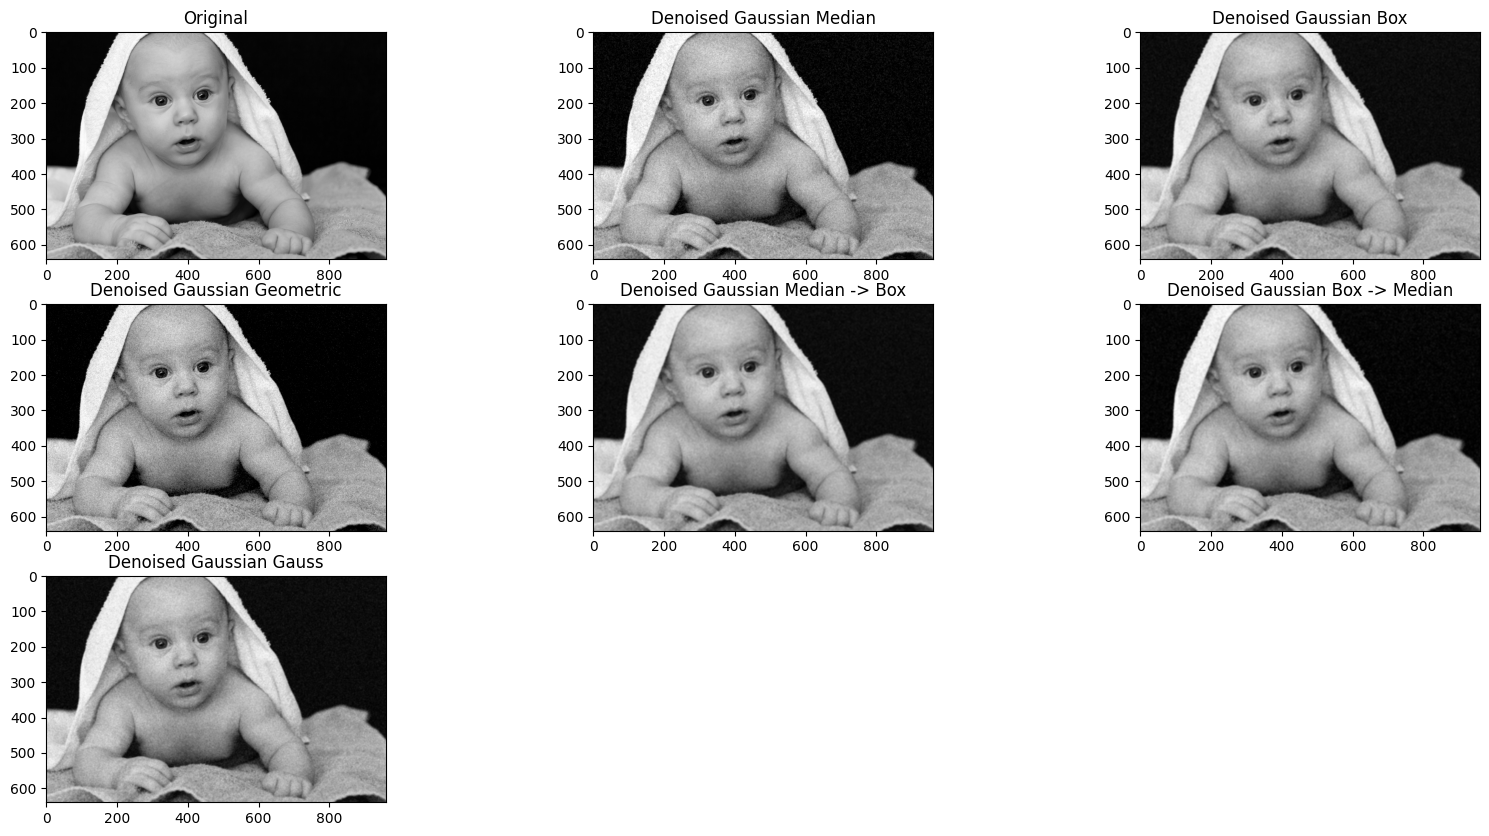

In [ ]:

#Comparing
plt.figure(figsize=(20, 10))

plt.subplot(3, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original')

plt.subplot(3, 3, 2)
plt.imshow(cv2.cvtColor(denoised_gauss_med, cv2.COLOR_BGR2RGB))
plt.title('Denoised Gaussian Median')

plt.subplot(3, 3, 3)
plt.imshow(cv2.cvtColor(denoised_gauss_box, cv2.COLOR_BGR2RGB))
plt.title('Denoised Gaussian Box')

plt.subplot(3, 3, 4)
plt.imshow(cv2.cvtColor(denoised_gauss_geometric, cv2.COLOR_BGR2RGB))
plt.title('Denoised Gaussian Geometric')

plt.subplot(3, 3, 5)
plt.imshow(cv2.cvtColor(denoised_gauss_MedtoBox, cv2.COLOR_BGR2RGB))
plt.title('Denoised Gaussian Median -> Box')

plt.subplot(3, 3, 6)
plt.imshow(cv2.cvtColor(denoised_gauss_BoxtoMed, cv2.COLOR_BGR2RGB))
plt.title('Denoised Gaussian Box -> Median')

plt.subplot(3,3,7)
plt.imshow(cv2.cvtColor(denoised_gauss_gauss, cv2.COLOR_BGR2RGB))
plt.title('Denoised Gaussian Gauss')

In [ ]:
from IPython.display import HTML

# Calculate and store SSIM scores in a dictionary
ssim_scores = {
    "Median": calculate_ssim(img, denoised_gauss_med),
    "Box": calculate_ssim(img, denoised_gauss_box),
    "Geometric": calculate_ssim(img, denoised_geometric_mean),
    "Median->Box": calculate_ssim(img, denoised_gauss_MedtoBox),
    "Box->Median": calculate_ssim(img, denoised_gauss_BoxtoMed),
    "Gaussian": calculate_ssim(img, denoised_gauss_gauss)
}

mse_scores = {
    "Median": calculate_mse(img, denoised_gauss_med),
    "Box": calculate_mse(img, denoised_gauss_box),
    "Geometric": calculate_mse(img, denoised_geometric_mean),
    "Median->Box": calculate_mse(img, denoised_gauss_MedtoBox),
    "Box->Median": calculate_mse(img, denoised_gauss_BoxtoMed),
    "Gaussian": calculate_mse(img, denoised_gauss_gauss)
}

psnr_scores = {
    "Median": calculate_psnr(img, denoised_gauss_med),
    "Box": calculate_psnr(img, denoised_gauss_box),
    "Geometric": calculate_psnr(img, denoised_geometric_mean),
    "Median->Box": calculate_psnr(img, denoised_gauss_MedtoBox),
    "Box->Median": calculate_psnr(img, denoised_gauss_BoxtoMed),
    "Gaussian": calculate_psnr(img, denoised_gauss_gauss)
}

best_ssim_denoiser = max(ssim_scores, key=ssim_scores.get)
best_mse_denoiser = min(mse_scores, key=mse_scores.get)
best_psnr_denoiser = max(psnr_scores, key=psnr_scores.get)

print("SSIM Scores:")
for denoiser, ssim_score in ssim_scores.items():
    color = "#00FF00" if denoiser == best_ssim_denoiser else "black"  # Green for best SSIM
    display(HTML(f"<span style='color: {color};'>{denoiser}: {ssim_score}{' <--- BEST' if denoiser == best_ssim_denoiser else ''}</span>"))

print("\nMSE Scores:")
for denoiser, mse_score in mse_scores.items():
    color = "#00FF00" if denoiser == best_mse_denoiser else "black"  # Green for best (lowest) MSE
    display(HTML(f"<span style='color: {color};'>{denoiser}: {mse_score}{' <--- BEST' if denoiser == best_mse_denoiser else ''}</span>"))

print("\nPSNR Scores:")
for denoiser, psnr_score in psnr_scores.items():
    color = "#00FF00" if denoiser == best_psnr_denoiser else "black"  # Blue for best PSNR
    display(HTML(f"<span style='color: {color};'>{denoiser}: {psnr_score}{' <--- BEST' if denoiser == best_psnr_denoiser else ''}</span>"))

SSIM: 0.5412910388904586; Poor Match
SSIM: 0.7145396358232122; Poor Match
SSIM: 0.28615789634045535; Poor Match
SSIM: 0.7488693415492855; Poor Match
SSIM: 0.7992540607501961; Poor Match
SSIM: 0.7071010856226468; Poor Match
MSE score: 56.05636555989583;  Acceptable Match
MSE score: 46.12199544270833; Very Good Match
MSE score: 36.546267903645834; Very Good Match
MSE score: 42.7517529296875; Very Good Match
MSE score: 29.374078776041667; Very Good Match
MSE score: 47.1358544921875; Very Good Match
PSNR score: 30.644554242122773; Very Good Match
PSNR score: 31.49172272327421; Very Good Match
PSNR score: 32.502373273608725; Very Good Match
PSNR score: 31.821264342696164; Very Good Match
PSNR score: 33.45116105630851; Very Good Match
PSNR score: 31.39728976365115; Very Good Match
SSIM Scores:



MSE Scores:



PSNR Scores:
